In [4]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
TOP_LATENT_DIM = 4
BOTTOM_LATENT_DIM = 8

image_data_dir = 'TEST'
image_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]
)

image_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input'
)

Found 3962 images belonging to 1 classes.


In [9]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.beta = beta

    def build(self, input_shape):
        self.embeddings = self.add_weight(
            shape=(self.num_embeddings, self.embedding_dim),
            initializer=tf.keras.initializers.RandomUniform(-1/self.num_embeddings, 1/self.num_embeddings),
            trainable=True,
            name='embeddings'
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flat_x = tf.reshape(x, (-1, self.embedding_dim))

        distances = (
            tf.reduce_sum(flat_x**2, axis=1, keepdims=True) 
            + tf.reduce_sum(self.embeddings**2, axis=1) 
            - 2 * tf.matmul(flat_x, self.embeddings, transpose_b=True)
        )
        
        encoding_indices = tf.argmin(distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings)
        
        quantized = tf.reshape(quantized, input_shape)
        
        commitment_loss = tf.reduce_mean(tf.square(tf.stop_gradient(quantized) - x))
        codebook_loss = tf.reduce_mean(tf.square(quantized - tf.stop_gradient(x)))
        
        quantized = x + tf.stop_gradient(quantized - x)
        
        extra_loss = self.beta * commitment_loss + codebook_loss
        self.add_loss(extra_loss)
        
        return quantized, encoding_indices

def build_top_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Downsample by factor of 8
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(512, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(TOP_LATENT_DIM, (3, 3), activation=None, padding='same')(x)
    
    return tf.keras.Model(inputs, x, name='top_encoder')

def build_bottom_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Downsample by factor of 4
    x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(BOTTOM_LATENT_DIM, (3, 3), activation=None, padding='same')(x)
    
    return tf.keras.Model(inputs, x, name='bottom_encoder')

def build_top_decoder(embedding_dim):
    inputs = layers.Input(shape=(None, None, embedding_dim))
    
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(256, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Conv2D(BOTTOM_LATENT_DIM, (3, 3), activation=None, padding='same')(x)
    
    return tf.keras.Model(inputs, outputs, name='top_decoder')

def build_bottom_decoder(embedding_dim):
    inputs = layers.Input(shape=(None, None, embedding_dim))
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(32, (4, 4), activation='relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(inputs, outputs, name='bottom_decoder')

class VQVAE2(tf.keras.Model):
    def __init__(self, top_encoder, bottom_encoder, top_decoder, bottom_decoder, 
                 num_embeddings, top_embedding_dim, bottom_embedding_dim, **kwargs):
        super(VQVAE2, self).__init__(**kwargs)
        
        self.top_encoder = top_encoder
        self.bottom_encoder = bottom_encoder
        self.top_decoder = top_decoder
        self.bottom_decoder = bottom_decoder
        
        self.top_vq = VectorQuantizer(num_embeddings, top_embedding_dim, name='top_vq')
        self.bottom_vq = VectorQuantizer(num_embeddings, bottom_embedding_dim, name='bottom_vq')
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.top_vq_loss_tracker = tf.keras.metrics.Mean(name="top_vq_loss")
        self.bottom_vq_loss_tracker = tf.keras.metrics.Mean(name="bottom_vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.top_vq_loss_tracker,
            self.bottom_vq_loss_tracker
        ]

    def call(self, inputs):
        top_encoded = self.top_encoder(inputs)
        top_quantized, _ = self.top_vq(top_encoded)
        top_decoded = self.top_decoder(top_quantized)

        bottom_encoded = self.bottom_encoder(inputs)
        bottom_encoded = bottom_encoded + top_decoded
        bottom_quantized, _ = self.bottom_vq(bottom_encoded)

        reconstructed = self.bottom_decoder(bottom_quantized)
        
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            top_encoded = self.top_encoder(data)
            top_quantized, _ = self.top_vq(top_encoded)
            top_decoded = self.top_decoder(top_quantized)

            bottom_encoded = self.bottom_encoder(data)
            bottom_encoded = bottom_encoded + top_decoded
            bottom_quantized, _ = self.bottom_vq(bottom_encoded)
            reconstructed = self.bottom_decoder(bottom_quantized)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed),
                    axis=[1, 2]
                )
            )
            
            top_vq_loss = sum(self.top_vq.losses)
            bottom_vq_loss = sum(self.bottom_vq.losses)
            
            total_loss = reconstruction_loss * 10 + top_vq_loss + bottom_vq_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        grads, _ = tf.clip_by_global_norm(grads, 5.0)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.top_vq_loss_tracker.update_state(top_vq_loss)
        self.bottom_vq_loss_tracker.update_state(bottom_vq_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "top_vq_loss": self.top_vq_loss_tracker.result(),
            "bottom_vq_loss": self.bottom_vq_loss_tracker.result()
        }

NUM_EMBEDDINGS = 512
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

top_encoder = build_top_encoder(input_shape)
bottom_encoder = build_bottom_encoder(input_shape)
top_decoder = build_top_decoder(TOP_LATENT_DIM)
bottom_decoder = build_bottom_decoder(BOTTOM_LATENT_DIM)

vqvae2 = VQVAE2(
    top_encoder, bottom_encoder,
    top_decoder, bottom_decoder,
    NUM_EMBEDDINGS, TOP_LATENT_DIM, BOTTOM_LATENT_DIM
)

vqvae2.compile(optimizer=Adam(learning_rate=0.0001))

history = vqvae2.fit(
    image_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - bottom_vq_loss: 1.3669 - loss: 1978983.7500 - reconstruction_loss: 34746.8672 - top_vq_loss: 1631513.6250
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - bottom_vq_loss: 4.4576 - loss: 3930788864.0000 - reconstruction_loss: 34713.6758 - top_vq_loss: 3930442240.0000
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - bottom_vq_loss: 4.6681 - loss: 58524692480.0000 - reconstruction_loss: 34720.7812 - top_vq_loss: 58524340224.0000
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - bottom_vq_loss: 4.8774 - loss: 133598134272.0000 - reconstruction_loss: 34715.6328 - top_vq_loss: 133597790208.0000
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - bottom_vq_loss: 5.3513 - loss: 403236323328.0000 - reconstruction_loss: 34715.9297 - top_vq_loss: 403235897344.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


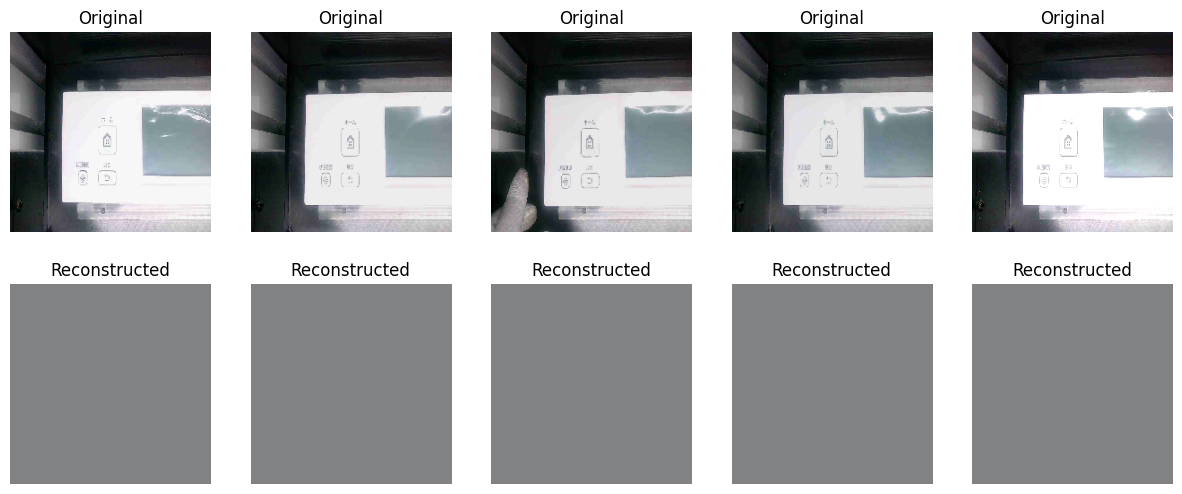

In [10]:
import matplotlib.pyplot as plt

# 원본과 재구성 이미지를 비교하는 함수
def visualize_reconstructions(model, data_iterator, num_images=5):
    # 데이터 한 배치를 가져옴
    original_images, _ = next(data_iterator)  # 배치에서 (이미지, 레이블) 반환
    
    # 배치 크기 확인
    batch_size = original_images.shape[0]
    
    # num_images를 배치 크기로 제한
    num_images = min(num_images, batch_size)
    
    # num_images만큼의 이미지만 선택
    original_images = original_images[:num_images]

    # 모델로 재구성
    reconstructed_images = model.predict(original_images)

    # 시각화
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # 원본 이미지
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # 재구성 이미지
        ax = plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.show()

# 시각화 호출
visualize_reconstructions(vqvae2, image_generator, num_images=5)
